# Sprint 3:

## Limpieza de los datos

In [10]:
import pandas as pd


nombre_documento = r'datos_3.csv'
df= pd.read_csv(nombre_documento, sep=',')


df


df

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,NaN,Private room,2,2.0,1.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,75.0,spain,malaga,31/07/2018
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1.0,1.0,...,90.0,100.0,100.0,80.0,90.0,FALSO,52.0,spain,madrid,10/01/2020
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.0,2.0,...,100.0,100.0,100.0,100.0,100.0,VERDADERO,142.0,spain,sevilla,29/07/2019
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.0,1.0,...,90.0,100.0,100.0,100.0,90.0,VERDADERO,306.0,spain,barcelona,10/01/2020
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,NaN,Private room,5,1.0,2.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,39.0,spain,girona,19/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,47710189,Beautiful house in the centre in Santa Cristin...,Beautiful house in the center of Santa Cristin...,263841355,Santa Cristina d'Aro,NaN,Entire home/apt,8,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,girona,31/01/2021
9996,47752964,Costa Brava - Palafrugell - playa y monta�a,Piso con acceso directo a piscina. Lugar muy t...,282214688,Palafrugell,NaN,Entire home/apt,7,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,girona,27/02/2021
9997,47792016,MODERN AND BRIGHT NEW FLAT IN THE CENTER OF PA...,Modern and new apartment in the old town of Pa...,263841355,Palam�s,NaN,Entire home/apt,6,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,girona,31/01/2021
9998,47884481,MIT House Olavide III in Madrid,The apartment is in a characteristic building ...,377605855,Trafalgar,Chamber�,Entire home/apt,4,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,madrid,09/02/2021


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 9650 non-null   int64  
 1   name                         9647 non-null   object 
 2   description                  9516 non-null   object 
 3   host_id                      9650 non-null   int64  
 4   neighbourhood_name           9650 non-null   object 
 5   neighbourhood_district       5860 non-null   object 
 6   room_type                    9650 non-null   object 
 7   accommodates                 9650 non-null   int64  
 8   bathrooms                    9650 non-null   float64
 9   bedrooms                     9650 non-null   float64
 10  beds                         9650 non-null   float64
 11  amenities_list               9634 non-null   object 
 12  price                        9650 non-null   float64
 13  minimum_nights    

### Importación BBDD de MySQL con archivo .csv

In [ ]:
import pandas as pd

# Hay que cambiar la ruta según carpeta docs guardados

df = pd.read_csv(r"C:\Users\giuia\OneDrive\SIMULADOR\Simulador\Sprint_3\datos_3.csv", sep=',', encoding='utf-8')
df


,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,NaN,Private room,2,2.0,1.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,75.0,spain,malaga,31/07/2018
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1.0,1.0,...,90.0,100.0,100.0,80.0,90.0,FALSO,52.0,spain,madrid,10/01/2020
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.0,2.0,...,100.0,100.0,100.0,100.0,100.0,VERDADERO,142.0,spain,sevilla,29/07/2019
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.0,1.0,...,90.0,100.0,100.0,100.0,90.0,VERDADERO,306.0,spain,barcelona,10/01/2020
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,NaN,Private room,5,1.0,2.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,39.0,spain,girona,19/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,47710189,Beautiful house in the centre in Santa Cristin...,Beautiful house in the center of Santa Cristin...,263841355,Santa Cristina d'Aro,NaN,Entire home/apt,8,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,girona,31/01/2021
9996,47752964,Costa Brava - Palafrugell - playa y monta�a,Piso con acceso directo a piscina. Lugar muy t...,282214688,Palafrugell,NaN,Entire home/apt,7,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,girona,27/02/2021
9997,47792016,MODERN AND BRIGHT NEW FLAT IN THE CENTER OF PA...,Modern and new apartment in the old town of Pa...,263841355,Palam�s,NaN,Entire home/apt,6,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,girona,31/01/2021
9998,47884481,MIT House Olavide III in Madrid,The apartment is in a characteristic building ...,377605855,Trafalgar,Chamber�,Entire home/apt,4,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,madrid,09/02/2021


### Eliminación de casos duplicados en la FK 'apartment_id': 

Creación de un df que solo contenga los casos duplicados para poderlos examinar

In [10]:
# Suponiendo que tu DataFrame se llama 'df'
df_duplicados = df[df.duplicated(subset=['apartment_id'], keep=False)].copy()

Para la eliminación de los casos duplicados en 'apartment_id' hemos usado la variable 'insert_date' quedandonos con la fecha más moderna y eliminando el resto de registros repetidos.

In [11]:
# Transformar la variable temporal a datetime especificando el formato
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')

# Ordena el DataFrame por 'apartment_id' y luego por 'insert_date' de forma descendente
df_ordenado = df.sort_values(by=['apartment_id', 'insert_date'], ascending=[True, False])

# Elimina los duplicados de 'apartment_id', quedándonos con el primero (el más reciente por el ordenamiento)
df_sin_duplicados = df_ordenado.drop_duplicates(subset=['apartment_id'], keep='first').copy()

# Si quieres resetear el índice del DataFrame resultante
df_sin_duplicados = df_sin_duplicados.reset_index(drop=True)

print(f"Tamaño del DataFrame original: {len(df)}")
print(f"Tamaño del DataFrame sin duplicados: {len(df_sin_duplicados)}")

Tamaño del DataFrame original: 8000
Tamaño del DataFrame sin duplicados: 7693


### Eliminación de datos nulls y transformación de variables:

#### Transformación de variables temporales:

In [12]:
# Convertir las variables temporales a datetime:
df_sin_duplicados['first_review_date'] = pd.to_datetime(df_sin_duplicados['first_review_date'], format='%d/%m/%Y')
df_sin_duplicados['last_review_date'] = pd.to_datetime(df_sin_duplicados['last_review_date'], format='%d/%m/%Y')

#### Transformación las variables 'bathrooms','bedrooms' y 'beds'
- Para poder poner las variables con el formato adecuado primero se ha hacer un tratamiendo de los datos nulls.
- Se ha imputado el valor de la mediana de los nulls usando otras variables como referencia para crear grupos homogeneos.

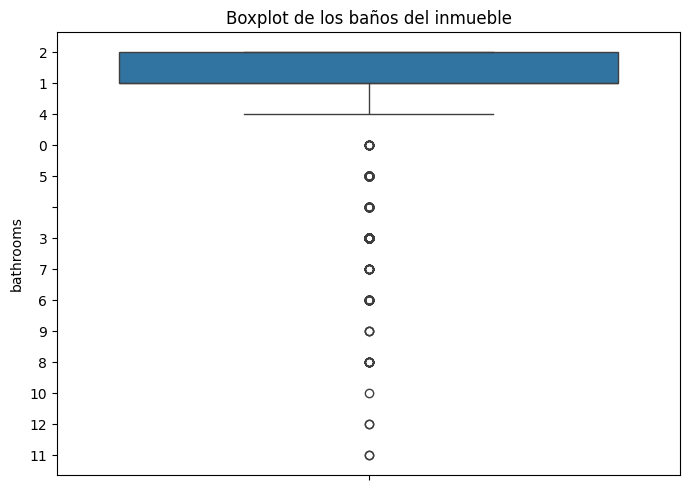

In [13]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['bathrooms'])
plt.xticks(rotation=45)
plt.title('Boxplot de los baños del inmueble')
plt.tight_layout()
plt.show()

In [14]:
import numpy as np

# Primero, convierte la columna 'bathrooms' a numérico, los errores se convierten a NaN
df_sin_duplicados['bathrooms'] = pd.to_numeric(df_sin_duplicados['bathrooms'], errors='coerce')

# Calcula la mediana de 'bathrooms' por cada número de 'accommodates'
mediana_bathrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['bathrooms'].median()

# Imputa los valores nulos en 'bathrooms' usando la mediana correspondiente al número de 'accommodates'
def imputar_bathrooms(row):
    if pd.isnull(row['bathrooms']):
        return mediana_bathrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['bathrooms'].median()) # Si no hay mediana para ese 'accommodates', usa la mediana general
    return row['bathrooms']

df_sin_duplicados['bathrooms'] = df_sin_duplicados.apply(imputar_bathrooms, axis=1)

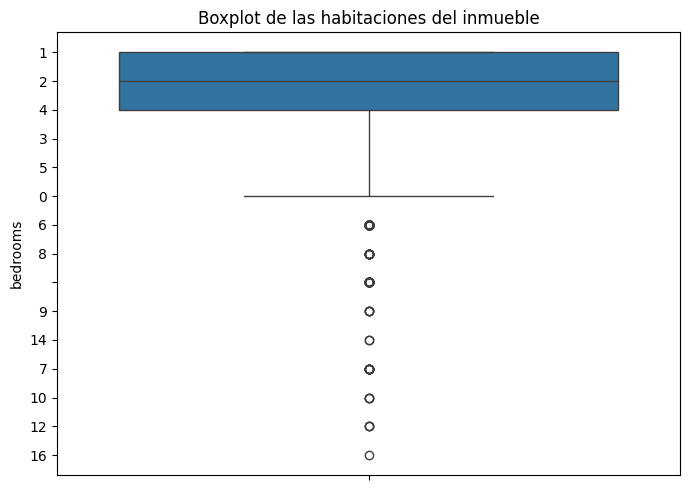

In [15]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['bedrooms'])
plt.xticks(rotation=45)
plt.title('Boxplot de las habitaciones del inmueble')
plt.tight_layout()
plt.show()

In [16]:
# Convertir la columna 'bedrooms' a numérico
df_sin_duplicados['bedrooms'] = pd.to_numeric(df_sin_duplicados['bedrooms'], errors='coerce')

# Calcular la mediana de 'bedrooms' por cada número de 'accommodates'
mediana_bedrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['bedrooms'].median()

# Imputar los valores nulos en 'bedrooms'
def imputar_bedrooms(row):
    if pd.isnull(row['bedrooms']):
        return mediana_bedrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['bedrooms'].median())
    return row['bedrooms']

df_sin_duplicados['bedrooms'] = df_sin_duplicados.apply(imputar_bedrooms, axis=1)

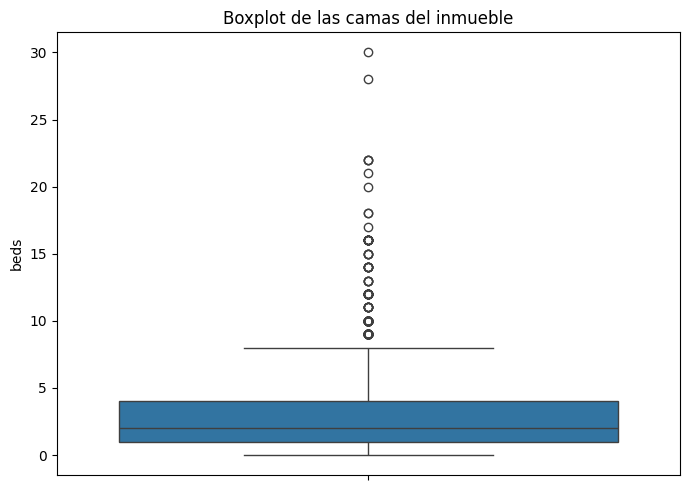

In [17]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['beds'])
plt.xticks(rotation=45)
plt.title('Boxplot de las camas del inmueble')
plt.tight_layout()
plt.show()

In [18]:
# Calcular la mediana de 'beds' por cada número de 'accommodates'
mediana_bedrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['beds'].median()

# Imputar los valores nulos en 'beds'
def imputar_bedrooms(row):
    if pd.isnull(row['beds']):
        return mediana_bedrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['beds'].median())
    return row['beds']

df_sin_duplicados['beds'] = df_sin_duplicados.apply(imputar_bedrooms, axis=1)

Para poder imputar en la variable 'price' un valor a los datos nulls se han usado las variables 'room_type' y 'city' para calcular la mediana de cada grupo y a esos grupos donde falta price se le ha aplicado la mediana que corresponde

### Imputación de valores en la variable 'price'

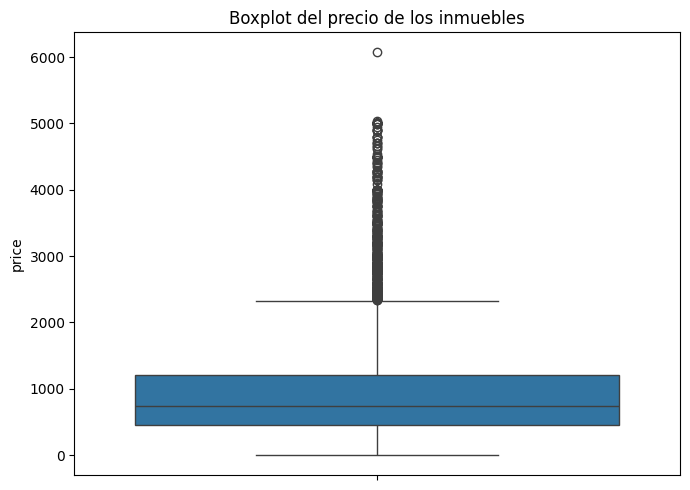

In [19]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['price'])
plt.xticks(rotation=45)
plt.title('Boxplot del precio de los inmuebles')
plt.tight_layout()
plt.show()

In [20]:
# Calcular la mediana de 'price' por 'city' y 'room_type'
mediana_price_por_city_roomtype = df_sin_duplicados.groupby(['city', 'room_type'])['price'].median()

# Función para imputar los valores nulos en 'price'
def imputar_price(row):
    if pd.isnull(row['price']):
        try:
            return mediana_price_por_city_roomtype[(row['city'], row['room_type'])]
        except KeyError:
            return df_sin_duplicados['price'].median() # Si no existe la combinación, usa la mediana general
    return row['price']

# Aplicar la imputación
df_sin_duplicados['price'] = df_sin_duplicados.apply(imputar_price, axis=1)

### Imputación de valores nulls en las variables score
 - La variable 'review_scores_rating' está en una escala diferente a las otras variables, así que he igualado su escala a la de las otras variables
 - Esta variable es la puntuación total

In [21]:
# Dividir entre 10 para ponerla en la misma escala que las otras variables
if df_sin_duplicados['review_scores_rating'].max() > 100:
    df_sin_duplicados['review_scores_rating'] = df_sin_duplicados['review_scores_rating'] / 10

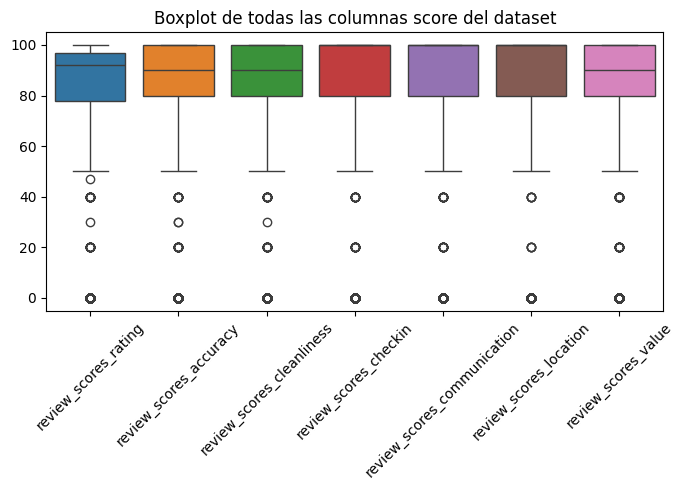

In [22]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados.iloc[:, 23:30])
plt.xticks(rotation=45)
plt.title('Boxplot de todas las columnas score del dataset')
plt.tight_layout()
plt.show()

In [23]:
columnas_a_imputar = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                       'review_scores_value', 'reviews_per_month']

for columna in columnas_a_imputar:
    # Imputar con la mediana del grupo
    df_sin_duplicados[columna] = df_sin_duplicados.groupby(['city', 'room_type'])[columna].transform(lambda x: x.fillna(x.median()))
    # Imputar los nulos restantes con la mediana de la columna completa
    mediana_global = df_sin_duplicados[columna].median()
    df_sin_duplicados[columna] = df_sin_duplicados[columna].fillna(mediana_global)

# Verificar la cantidad de nulos después de la imputación
print(df_sin_duplicados[columnas_a_imputar].isnull().sum())

review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
dtype: int64


### Transformación variable has_availability todos los casos verdadero:

Hemos sustitudo 534 valores nulls imputandoles el valor True y hemos transformado el valor VERDADERO en True

In [24]:
# Transformar VERDADERO a True
df_sin_duplicados['has_availability'] = df_sin_duplicados['has_availability'].replace('VERDADERO', True)

# Imputacion a valores nulls por True
df_sin_duplicados['has_availability'].fillna(True, inplace=True)

C:\Users\isana\AppData\Local\Temp\ipykernel_32124\1803279718.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sin_duplicados['has_availability'].fillna(True, inplace=True)


### Datos nulls que siguen existiendo en el dataset:

In [25]:
# 1. Identificar filas con al menos un valor nulo:
df_sin_duplicados[df_sin_duplicados.isnull().any(axis=1)]

# 2. Obtener el número de valores nulos por columna y filtrar las que tienen al menos uno:
nulos_por_columna = df_sin_duplicados.isnull().sum()

# 3. Eliminar las variables que no tienen nulls de la visualizacion:
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]
print("\nNúmero de valores nulos por columna (solo las que tienen nulos):")
print(columnas_con_nulos)


Número de valores nulos por columna (solo las que tienen nulos):
first_review_date    1554
last_review_date     1555
dtype: int64


### Transformación nombre dataset para crear archivo .csv y poder importar el documento en PowerBi

In [26]:
# Cambio del nombre del dataset
df_tourist = df_sin_duplicados

El código para crear el .csv esta comentado para que no lo cree cada vez que lo ejecutamos entero el script, si se hace algun cambio en el df_tourist se ha de modificar

In [27]:
# # Exportar el nuevo df como .csv
# nombre_archivo_csv = 'df_tourist_python.csv'
# df_tourist.to_csv(nombre_archivo_csv, index=False, encoding='utf-8', sep=';', decimal='.')

# nombre_archivo_csv = 'df_tourist.csv'
# df_tourist.to_csv(nombre_archivo_csv, index=False, encoding='utf-8', sep=';', decimal=',')



# # Mensaje sobre la operación realizada
# print(f"El DataFrame se ha guardado exitosamente en '{nombre_archivo_csv}'")

## EDA General

### Eda datos raw

importamos librerias:

In [3]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
from scipy.stats import shapiro
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

Inspeccionamos DF

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 10000 non-null  int64  
 1   name                         9997 non-null   object 
 2   description                  9862 non-null   object 
 3   host_id                      10000 non-null  int64  
 4   neighbourhood_name           10000 non-null  object 
 5   neighbourhood_district       6079 non-null   object 
 6   room_type                    10000 non-null  object 
 7   accommodates                 10000 non-null  int64  
 8   bathrooms                    9926 non-null   float64
 9   bedrooms                     9930 non-null   float64
 10  beds                         9955 non-null   float64
 11  amenities_list               9983 non-null   object 
 12  price                        9746 non-null   float64
 13  minimum_nights   

In [5]:
df.describe().round(2)

,apartment_id,host_id,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,10000.00,1.000000e+04,10000.00,9926.00,9930.00,9955.00,9746.00,10000.00,10000.00,10000.00,...,10000.00,10000.00,7291.00,7282.00,7288.00,7277.00,7286.00,7276.00,7276.00,7396.00
mean,21154398.27,9.058066e+07,4.27,1.60,1.94,2.92,1021.37,4.95,759.77,13.01,...,187.94,26.02,919.30,94.50,93.16,96.24,96.22,95.45,91.38,123.95
std,11579666.93,8.695851e+07,2.58,0.99,1.37,2.26,974.85,17.73,498.37,11.84,...,130.78,52.35,92.27,9.47,10.06,8.27,8.28,7.68,9.97,153.39
min,11964.00,1.070400e+04,1.00,0.00,0.00,0.00,60.00,1.00,1.00,0.00,...,0.00,0.00,200.00,20.00,20.00,20.00,20.00,20.00,20.00,1.00
25%,13286719.75,1.488728e+07,2.00,1.00,1.00,1.00,450.00,1.00,62.00,0.00,...,66.00,0.00,890.00,90.00,90.00,90.00,90.00,90.00,90.00,18.00
50%,20598467.50,6.533700e+07,4.00,1.00,2.00,2.00,750.00,2.00,1125.00,11.00,...,183.00,5.00,940.00,100.00,100.00,100.00,100.00,100.00,90.00,58.00
75%,29959987.25,1.428246e+08,6.00,2.00,3.00,4.00,1240.00,4.00,1125.00,26.00,...,318.00,27.00,980.00,100.00,100.00,100.00,100.00,100.00,100.00,178.00
max,48061552.00,3.874783e+08,29.00,13.00,50.00,30.00,28571.00,1125.00,1125.00,30.00,...,365.00,588.00,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1291.00


#### Variabilidad/distribución variable precio:

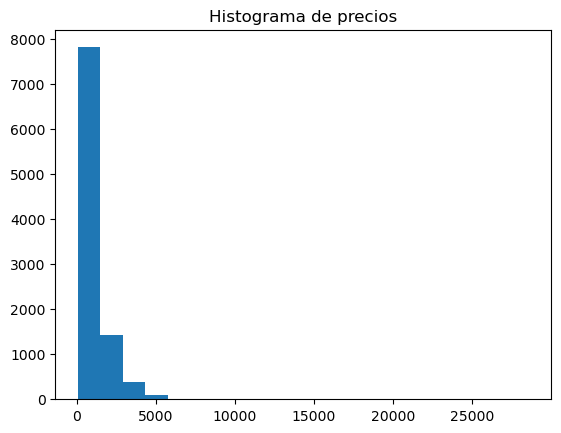

In [6]:
# Ajustamos la escala del eje Y para mostrar números completos ( sin notación cientifica por default)
plt.ticklabel_format(style='plain', axis='y')

plt.title('Histograma de precios')
plt.hist(df['price'], bins=20)
plt.show()

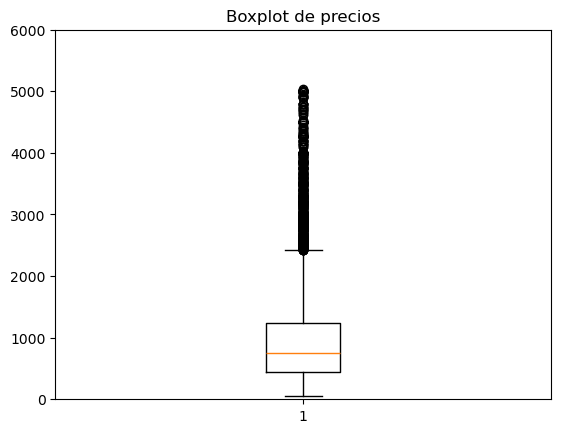

In [7]:
plt.boxplot(df['price'].dropna()) # quitamos los nan para evitar anomalias 
plt.ylim(0, 6000)  # Ajustamos los límites según los valores del dataset
plt.title('Boxplot de precios')
plt.show()



Identificación/tratamiento de Outliers:

In [8]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para considerar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para mantener solo los valores dentro de los límites
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

Volvemos a graficar la variable trás el tratamiento de los Outliers

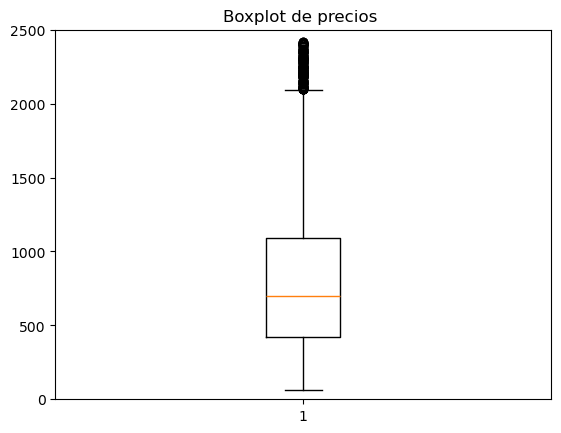

In [9]:
plt.boxplot(df_filtered['price'].dropna()) # quitamos los nan para evitar anomalias 
plt.ylim(0, 2500)  # Ajustamos los límites según los valores del dataset
plt.title('Boxplot de precios ')
plt.show()

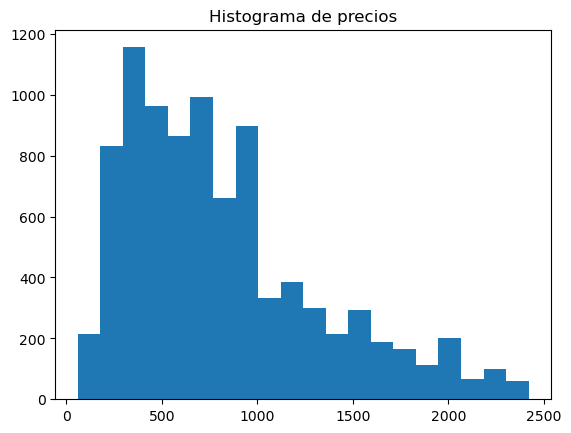

In [10]:
# Ajustamos la escala del eje Y para mostrar números completos ( sin notación cientifica por default)
plt.ticklabel_format(style='plain', axis='y')

# Histograma 
plt.title('Histograma de precios')
plt.hist(df_filtered['price'], bins=20)
plt.show()

In [11]:
df_filtered['price'].describe().round(2)

count    8998.00
mean      817.98
std       508.79
min        60.00
25%       422.50
50%       700.00
75%      1090.00
max      2420.00
Name: price, dtype: float64

In [12]:
df['price'].var().round(2)

AttributeError: 'float' object has no attribute 'round'

Verificamos dispersión de la variable price

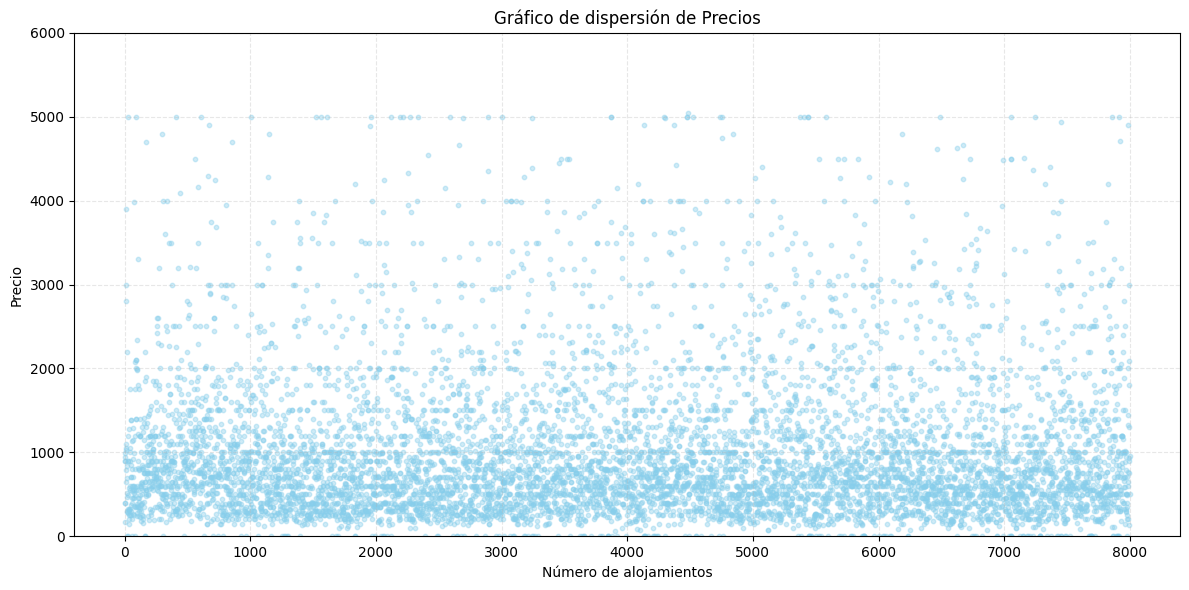

In [ ]:
# Eliminamos los NaN
price_nonan = df['price'].dropna()

plt.figure(figsize=(12, 6))
plt.scatter(price_nonan.index, price_nonan, alpha=0.4, color='skyblue', s=10)
plt.ylim(0, 6000)
plt.title('Gráfico de dispersión de Precios')
plt.xlabel('Número de alojamientos')
plt.ylabel('Precio')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### Boxplot availability 

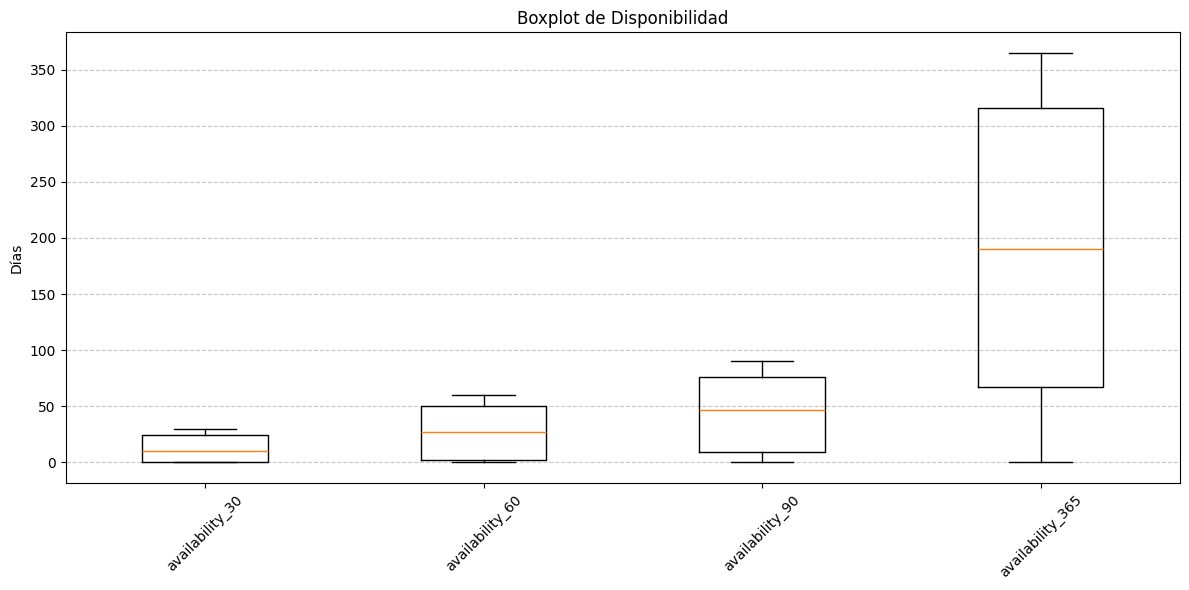

In [ ]:
# Lista de variables
variables = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Crear el boxplot
plt.figure(figsize=(12, 6))
plt.boxplot([df[var].dropna() for var in variables], labels=variables)
plt.title('Boxplot de Disponibilidad')
plt.ylabel('Días')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### EDA sobre df_tourist ( Dataframe limpio)

In [ ]:
df_tourist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7693 entries, 0 to 7692
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7693 non-null   object        
 2   description                  7693 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       7693 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7693 non-null   float64       
 9   bedrooms                     7693 non-null   float64       
 10  beds                         7693 non-null   int64         
 11  amenities_list               7693 non-null 

#### Boxplot bathrooms - bedrooms - beds - accommodates

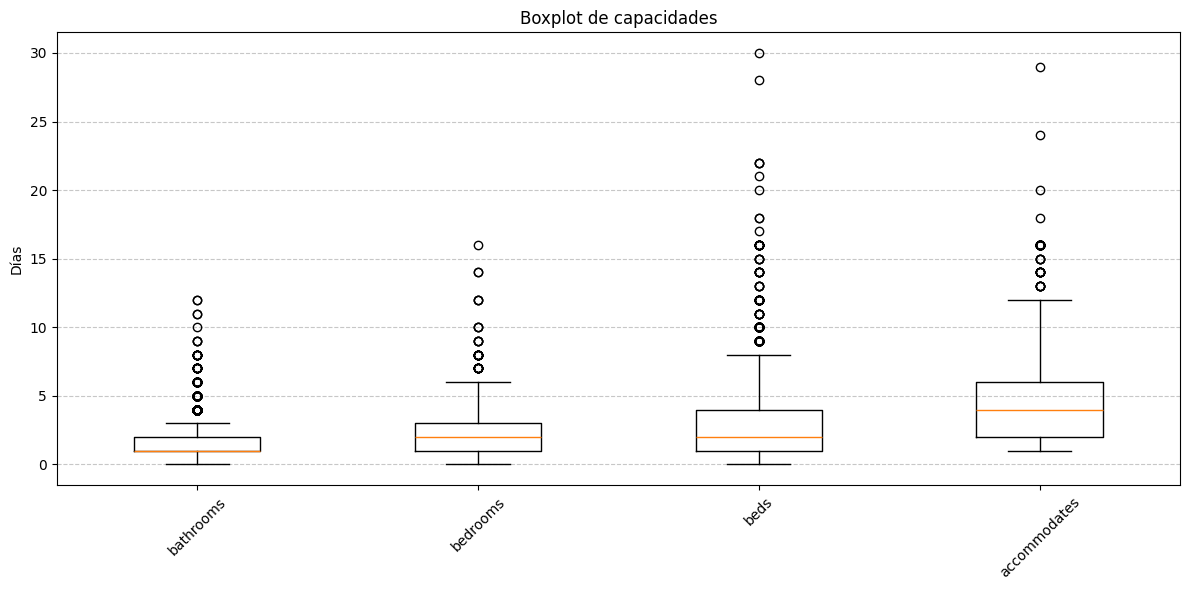

In [ ]:
# Lista de variables
variables = ['bathrooms', 'bedrooms', 'beds', 'accommodates']

# Crear el boxplot
plt.figure(figsize=(12, 6))
plt.boxplot([df_tourist[var].dropna() for var in variables], labels=variables)
plt.title('Boxplot de capacidades')
plt.ylabel('Días')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Exploración de relaciones entre variables 

Verificamos tipo de distribución de las variables price/accommodates/beds/bedrooms mediante Shapiro Wilk test

In [ ]:
# Prueba de normalidad para cada variable
stat_price, p_price = shapiro(df_tourist['price'])
stat_accom, p_accom = shapiro(df_tourist['accommodates'])
stat_beds, p_beds = shapiro(df_tourist['beds'])
stat_bedrooms, p_bedrooms = shapiro(df_tourist['bedrooms'])

# Resultados
print(f"Shapiro-Wilk Test para 'price': Estadístico={stat_price:.4f}, p-valor={p_price:.4f}")
print(f"Shapiro-Wilk Test para 'accommodates': Estadístico={stat_accom:.4f}, p-valor={p_accom:.4f}")
print(f"Shapiro-Wilk Test para 'beds': Estadístico={stat_beds:.4f}, p-valor={p_beds:.4f}")
print(f"Shapiro-Wilk Test para 'bedrooms': Estadístico={stat_bedrooms:.4f}, p-valor={p_bedrooms:.4f}")

# Interpretación
alpha = 0.05

def interpret_shapiro(p_value, variable_name):
    if p_value > alpha:
        print(f"La variable '{variable_name}' sigue una distribución normal (p > 0.05)")
    else:
        print(f"La variable '{variable_name}' NO sigue una distribución normal (p <= 0.05)")

interpret_shapiro(p_price, 'price')
interpret_shapiro(p_accom, 'accommodates')
interpret_shapiro(p_beds, 'beds')
interpret_shapiro(p_bedrooms, 'bedrooms')

Shapiro-Wilk Test para 'price': Estadístico=0.8003, p-valor=0.0000
Shapiro-Wilk Test para 'accommodates': Estadístico=0.8883, p-valor=0.0000
Shapiro-Wilk Test para 'beds': Estadístico=0.8059, p-valor=0.0000
Shapiro-Wilk Test para 'bedrooms': Estadístico=0.8113, p-valor=0.0000
La variable 'price' NO sigue una distribución normal (p <= 0.05)
La variable 'accommodates' NO sigue una distribución normal (p <= 0.05)
La variable 'beds' NO sigue una distribución normal (p <= 0.05)
La variable 'bedrooms' NO sigue una distribución normal (p <= 0.05)


verificamos coeficiente de correlación de Spearman:

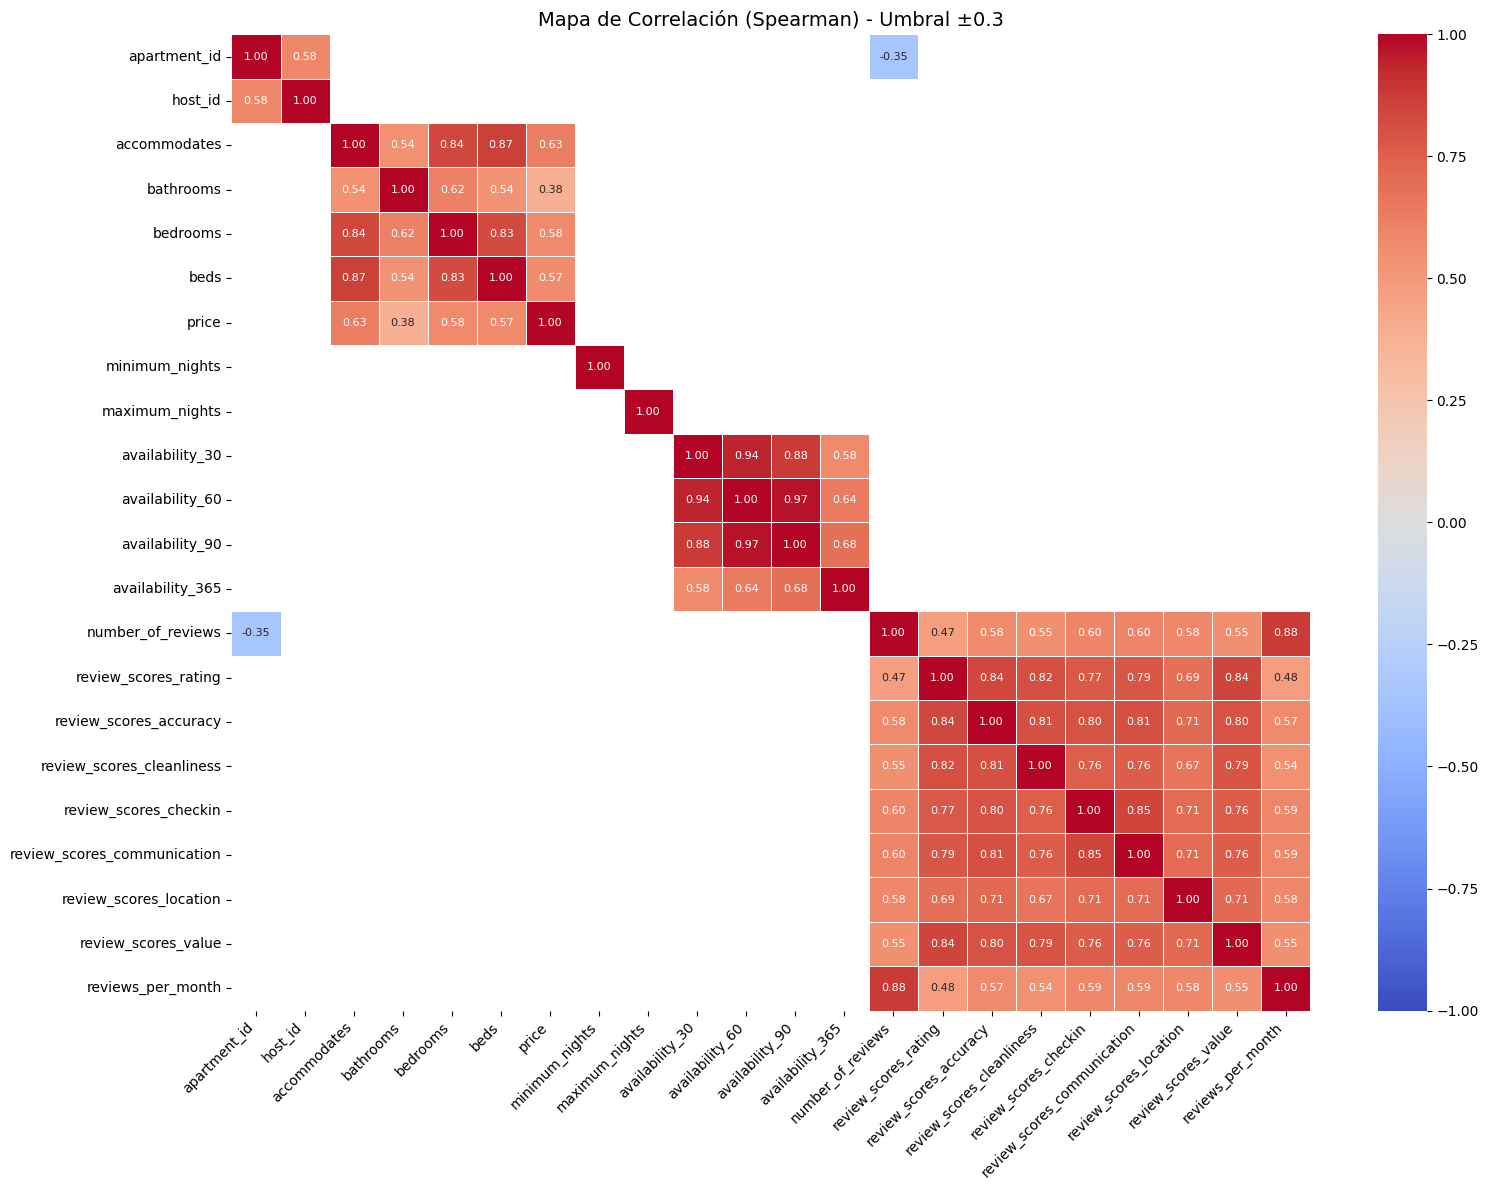

In [ ]:
# Seleccionar solo las columnas numéricas
numericas = df_tourist.select_dtypes(include=['float64', 'int64'])

# Verificar si hay nulos
numericas = numericas.dropna()

# Umbral
threshold = 0.3

# Matriz de correlación utilizando Spearman
corr_spearman = numericas.corr(method='spearman')

# Aplicamos el umbral: valores menores al umbral se establecen en NaN
corr_spearman_masked = corr_spearman.mask((corr_spearman < threshold) & (corr_spearman > -threshold))

# Tamaño del gráfico
plt.figure(figsize=(16, 12))

# Heatmap ajustado
sns.heatmap(
    corr_spearman_masked, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    cbar=True, 
    annot_kws={"size": 8},  # Tamaño del texto
    fmt=".2f",
    mask=corr_spearman_masked.isnull(),  # quitamos los valores no significativos
    linewidths=0.5  # Línea entre celdas para mejorar visibilidad
)

plt.title('Mapa de Correlación (Spearman) - Umbral ±0.3', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

En los gráficos a continuación  muestra la relación entre el **precio** y la **capacidad de alojamiento**/**numero de camas**/**numero de baños** de las propiedades, usando un ajuste de regresión polinómica de segundo orden. Además, se segmenta por **tipo de habitación** para entender cómo varía el precio en función del tipo de alojamiento.

Relación entre Precio y Capacidad alojamiento

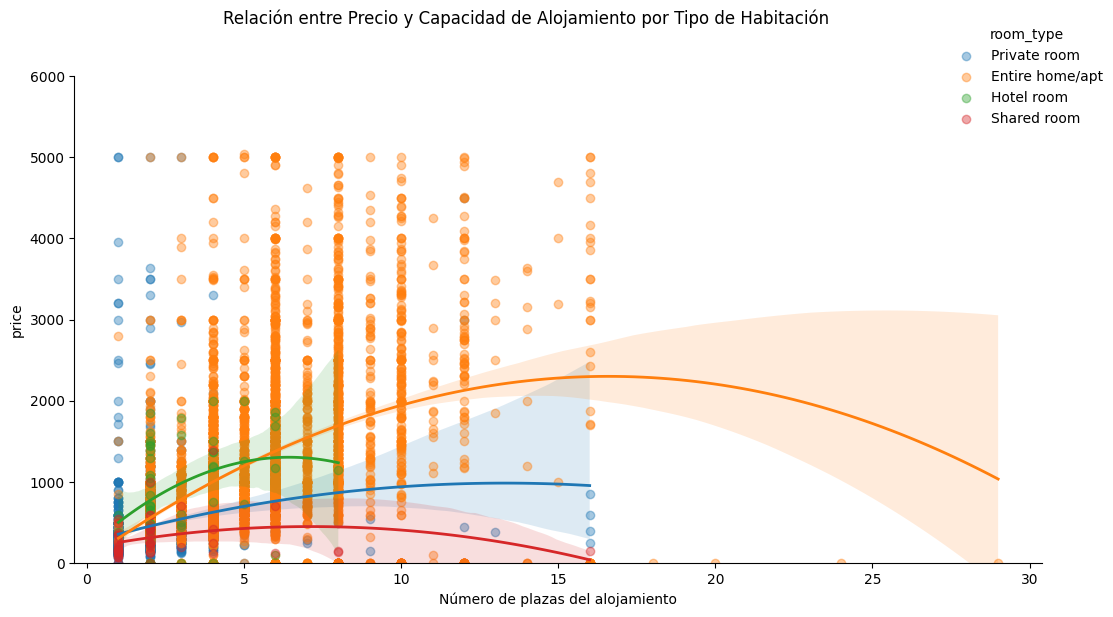

In [ ]:
# Incluir 'room_type' en el DataFrame filtrado
df_filtered = df[['price', 'accommodates', 'room_type']]

# Crear el gráfico
g = sns.lmplot(
    x='accommodates',
    y='price',
    data=df_filtered,
    hue='room_type',
    order=2,  
    height=6,
    aspect=1.5,
    scatter_kws={'alpha': 0.4},
    line_kws={'linewidth': 2}
)

# Ajustar límites del eje Y
plt.ylim(0, 6000)

# Mover la leyenda hacia la derecha y un poco más arriba
g._legend.set_bbox_to_anchor((1.05, 0.9))  # Mover más arriba

# Ajustar el título del gráfico
plt.subplots_adjust(top=0.9)  # Espacio superior
plt.suptitle('Relación entre Precio y Capacidad de Alojamiento por Tipo de Habitación', y=1.02)
plt.xlabel('Número de plazas del alojamiento')

plt.tight_layout()
plt.show()


Relación entre Precio y Número de Camas

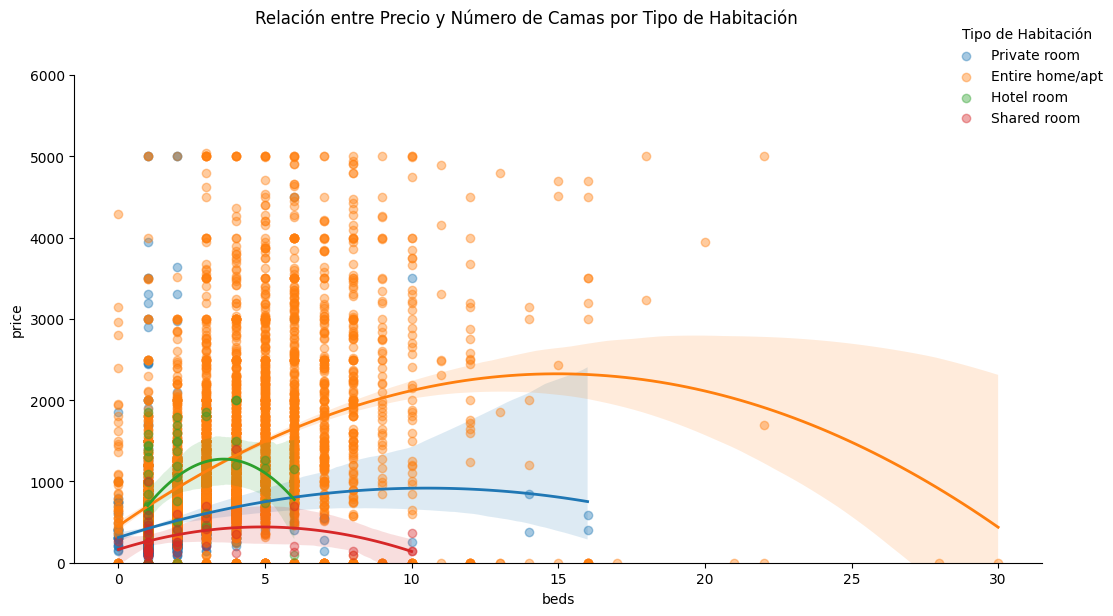

In [ ]:
# Incluir 'room_type' en el DataFrame filtrado
df_filtered = df_tourist[['beds', 'price', 'room_type']].dropna()

import seaborn as sns
import matplotlib.pyplot as plt

# Crear el gráfico con ajuste polinómico
g = sns.lmplot(
    x='beds',
    y='price',
    data=df_filtered,
    hue='room_type',
    order=2,  
    height=6,
    aspect=1.5,
    scatter_kws={'alpha': 0.4},
    line_kws={'linewidth': 2}
)

# Ajustar límites del eje Y
plt.ylim(0, 6000)

# Mover la leyenda hacia la derecha y un poco más arriba
g._legend.set_bbox_to_anchor((1.05, 0.9))  # Mover más arriba
g._legend.set_title('Tipo de Habitación')

# Ajustar el título del gráfico
plt.subplots_adjust(top=0.9)
plt.suptitle('Relación entre Precio y Número de Camas por Tipo de Habitación', y=1.02)

plt.tight_layout()
plt.show()


Relación entre Precio y Número de Dormitorios

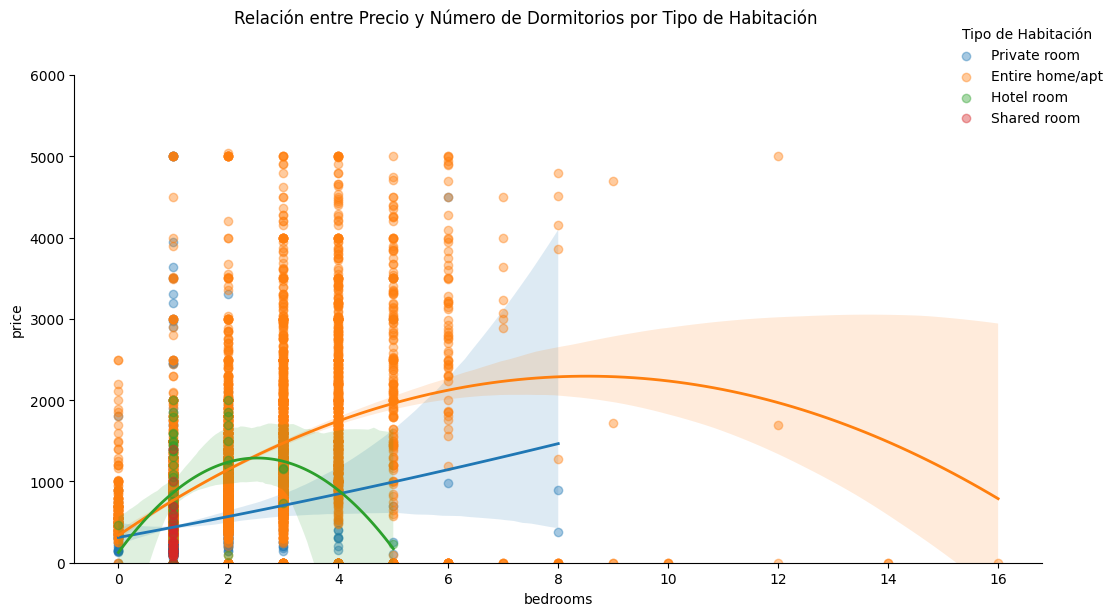

In [ ]:
# Incluir 'room_type' en el DataFrame filtrado
df_filtered = df_tourist[['bedrooms', 'price', 'room_type']]

# Crear el gráfico con ajuste polinómico
g = sns.lmplot(
    x='bedrooms',
    y='price',
    data=df_filtered,
    hue='room_type',
    order=2,  
    height=6,
    aspect=1.5,
    scatter_kws={'alpha': 0.4},
    line_kws={'linewidth': 2}
)

# Ajustar límites del eje Y
plt.ylim(0, 6000)

# Mover la leyenda hacia la derecha y un poco más arriba
g._legend.set_bbox_to_anchor((1.05, 0.9))
g._legend.set_title('Tipo de Habitación')

# Ajustar el título del gráfico
plt.subplots_adjust(top=0.9)
plt.suptitle('Relación entre Precio y Número de Dormitorios por Tipo de Habitación', y=1.02)

plt.tight_layout()
plt.show()

Distribución del precio por capacidad

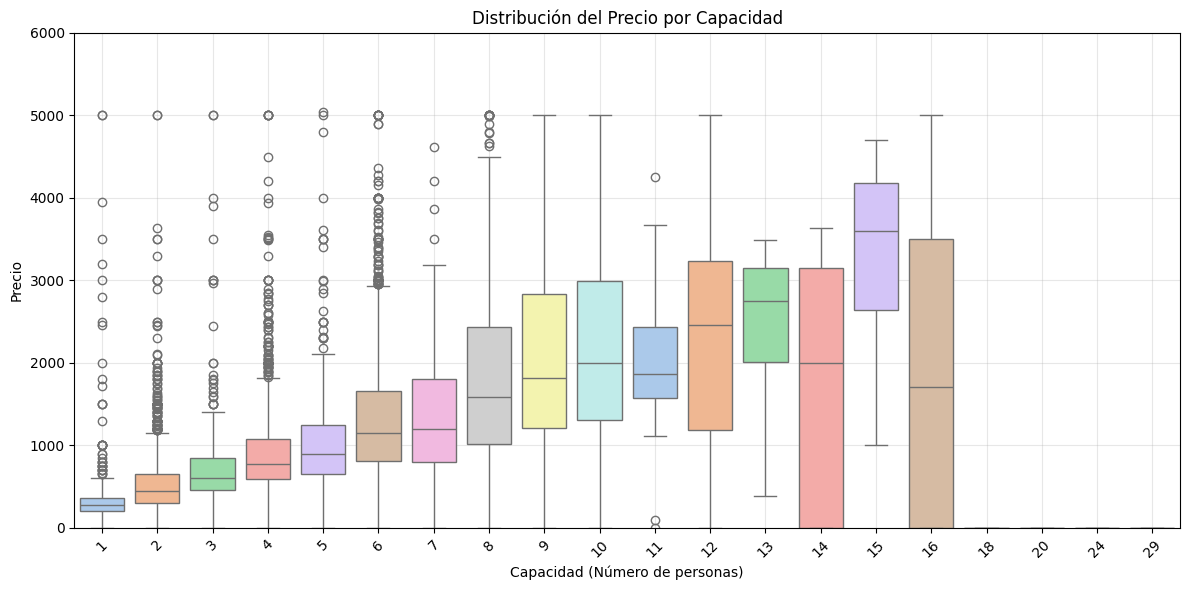

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_tourist, x='accommodates', y='price', palette='pastel')
plt.title('Distribución del Precio por Capacidad')
plt.xlabel('Capacidad (Número de personas)')
plt.ylabel('Precio')
plt.ylim(0, 6000)  # Ajustar según los valores del dataset
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()